In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 


from sklearn import metrics
import nltk
import os
from nltk.corpus import stopwords
from textblob import Word
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mandi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [265]:
df = pd.read_csv("Outlook_mail.csv")
df

,Subject,Body,Categories,Importance,Sensitivity
0,Welcome back email for Term 3 Freshmore,"Dear Cohort 2 Students,\n\n \n\nWelcome back f...",NaN,Normal,Normal
1,SC06 Group 8 HOA1 Submission,"Hi prof,\r\n\r\n Attached is ou...",NaN,Normal,Normal
2,🥋SUTD KARATE INTRO SESSION!!🥋,Hiya!\n\nReady to get a full body workout?!? P...,NaN,Normal,Normal
3,Register Now - SSIA Summit 2021 (30 Sept 2021),"Dear SUTD Community,\r\n\r\n \r\n\r\nYou are c...",NaN,Normal,Normal
4,HASS Minors Info Session,HAPPENING TODAY!\r\n\r\n \r\n\r\nDear Freshmor...,NaN,Normal,Normal
...,...,...,...,...,...
524,Natalie mentioned 10.020 Data Driven World (Fa...,External Email – Do not click on any links or ...,NaN,Normal,Normal
525,#ProjectYOU 2021 - Bold@Work Juraseek Playgrou...,\r\nHello there! \r\n\r\n \r\n\r\n \r\n\r\n ...,NaN,Normal,Normal
526,RE: [Update] Postponement of Lazarus Island Di...,"Hi all, \r\n\r\n \r\n\r\nIn view of the latest...",NaN,Normal,Normal
527,[Update] Athletics Introduction Session,"Dear Freshmore and SUTDents,\r\n\r\n\r\n\r\n\r...",NaN,Normal,Normal


In [266]:
df['Body'] = df['Body'].apply(lambda x: x.lower())
punctuations = ',\.\!\?'
df = (df.drop('Body',axis=1).merge(df.Body.str.extractall(f'(?P<Body>[^{punctuations}]+[{punctuations}])\s?').reset_index('match'),left_index=True, right_index=True, how='left'))
df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")
df = df.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '')
#print(type(df['Body']))
#df.applymap(type)
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
stop = stopwords.words("english") #remove useless words
df['Body'] = df['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df

,Subject,Categories,Importance,Sensitivity,match,Body
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,0.0,dear cohort 2 student
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,1.0,welcome back vacation
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,2.0,hope good 4 month break
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,3.0,many upcoming activity event cdc
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,4.0,head
...,...,...,...,...,...,...
528,Summary of coverage Highlights of SUTD,NaN,NaN,NaN,472.0,prospective applicant may refer ntu
528,Summary of coverage Highlights of SUTD,NaN,NaN,NaN,473.0,national university singapore
528,Summary of coverage Highlights of SUTD,NaN,NaN,NaN,474.0,singapore management university singapore univ...
528,Summary of coverage Highlights of SUTD,NaN,NaN,NaN,475.0,strait time


In [267]:
#vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

# max_df removes words that appears more than _%
# min_df removes words that appears less than _

vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 20,
                     max_df = 0.5,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
X = vect.fit_transform(df['Body'].values.astype('U'))

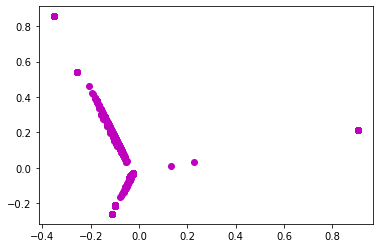

In [268]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [269]:
# top keywords in the emails

def top_tfidf_feats(row, features, top_n=20000):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

         features     score
0            back  0.740713
1         welcome  0.671822
2       zoom link  0.000000
3            free  0.000000
4         forward  0.000000
5  forward seeing  0.000000
6           found  0.000000
7      foundation  0.000000
8            four  0.000000
9       framework  0.000000


In [270]:
# top terms out of all the emails
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=20000):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

print(top_mean_feats(X, features, top_n=10))

            features     score
0                edu  0.064870
1               sutd  0.061311
2                com  0.050010
3         protection  0.048384
4            outlook  0.048339
5          safelinks  0.048295
6         httpsapc01  0.028542
7  urlhttps3a2f2fwww  0.013101
8             office  0.008355
9          instagram  0.007707


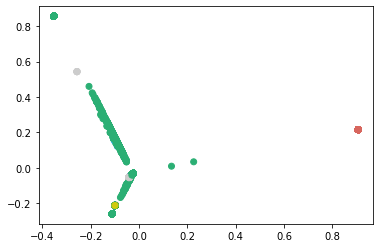

In [271]:
# Kmeans
from sklearn.cluster import KMeans
n_clusters = 5
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

# For larger datasets use mini-batch KMeans, so we dont have to read all data into memory.
# batch_size = 500
# clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
# clf.fit(X)

# Let's plot this with matplotlib to visualize it.
# First we need to make 2D coordinates from the sparse matrix.
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
# Plot clusters
plt.scatter(coords[:, 0], coords[:, 1], c=colors)





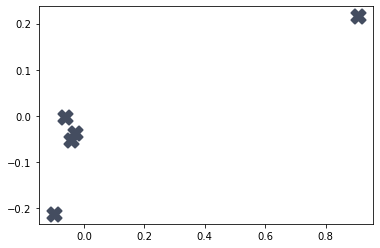

In [272]:
# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

In [273]:
# extracts the top terms per cluster
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

top_feats_per_cluster(X, labels, features, min_tfidf=0.1, top_n=10)

[               features     score
 0             instagram  0.879277
 1  instagram httpsapc01  0.142241
 2            httpsapc01  0.088246
 3      follow instagram  0.023442
 4                follow  0.020042
 5              httpswww  0.017012
 6                   try  0.003976
 7                 photo  0.003685
 8                 check  0.003565
 9                 video  0.003159,
             features     score
 0               sutd  0.071394
 1                com  0.058071
 2         protection  0.056438
 3          safelinks  0.056335
 4  urlhttps3a2f2fwww  0.015281
 5             office  0.009745
 6         httpsapc01  0.008826
 7               team  0.008661
 8                 sg  0.008551
 9               zoom  0.008360,
           features  score
 0              edu    1.0
 1        zoom link    0.0
 2             free    0.0
 3  form httpsapc01    0.0
 4          forward    0.0
 5   forward seeing    0.0
 6            found    0.0
 7       foundation    0.0
 8             fou

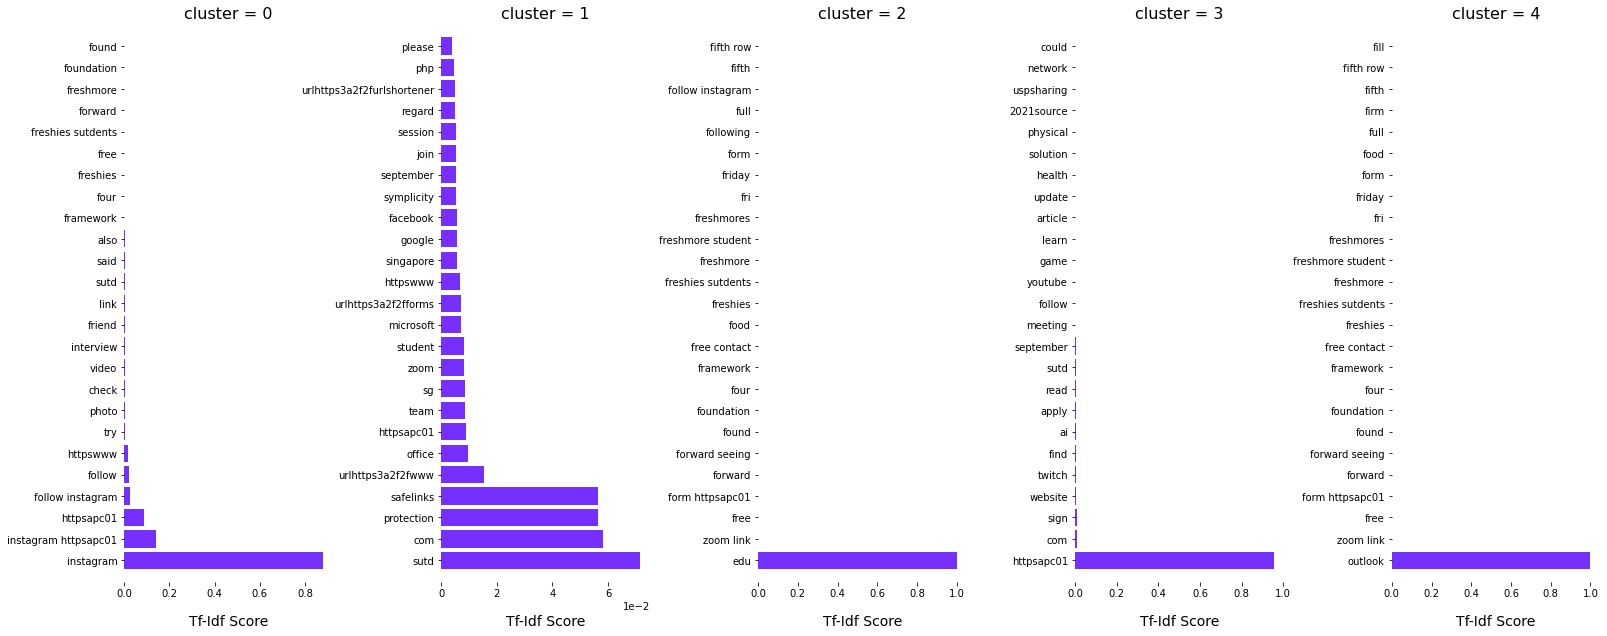

In [274]:
#Use this to print the top terms per cluster with matplotlib.

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(25, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

In [275]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

stopwords = ENGLISH_STOP_WORDS.union(['from', 'com', 'php', 'free'])
vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
vec_train = vec.fit_transform(df['Body'].values.astype('U'))

# print out the vector of the first email
print(vec_train[0:1])

  (0, 6777)	0.43756676660039356
  (0, 1541)	0.7257028617034457
  (0, 2237)	0.530933782389392


In [276]:
# The vector of the first email.
vec_train[0:1]

<1x7962 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [277]:
from sklearn.metrics.pairwise import linear_kernel

# Find cosine similarity between the first email and all others.
cosine_sim = linear_kernel(vec_train[0:1], vec_train).flatten()
print(cosine_sim)

[1. 0. 0. ... 0. 0. 0.]


In [278]:
vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
vec_train = vec.fit_transform(df.Body)

In [279]:
# Finding emails related to a query.
query = "qr"
# Transform the query into the original vector
vec_query = vec.transform([query])

In [280]:
# Find top 10 most related emails to the query.
related_email_indices = cosine_sim.argsort()[:-10:-1]
# print out the indices of the 10 most related emails.
print(related_email_indices)

[    0 13032 38427 26387 42627 42644 17769 21226  5123]


In [281]:
# Print out the first result
first_email_index = related_email_indices[0]
print(df.Body.to_numpy()[first_email_index])

dear cohort 2 student


In [288]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import linear_kernel
#from helpers import parse_into_emails

def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['Subject', 'Body']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['Body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'Body': map_to_list(emails, 'Body'), 
        'Subject': map_to_list(emails, 'Subject'), 
        'match': map_to_list(emails, 'match')
    }

def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

def read_email_bodies():
  emails = pd.read_csv('Outlook_mail.csv')
  email_df = pd.DataFrame(parse_into_emails(emails.Body))
  email_df.drop(email_df.query("Body == '' | Subject == '' | match == ''").index, inplace=True)
  email_df.drop_duplicates(inplace=True)
  return email_df['Body']


class EmailDataset: 
  def __init__(self):
    stopwords = ENGLISH_STOP_WORDS.union(['from', 'com', 'php', 'free'])
    self.vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
    self.emails = read_email_bodies() 

    # train on the given email data.
    self.train()
  
  def train(self):
    self.vec_train = self.vec.fit_transform(self.emails)
  
  def query(self, keyword, limit):
    vec_keyword = self.vec.transform([keyword])
    cosine_sim = linear_kernel(vec_keyword, self.vec_train).flatten()
    related_email_indices = cosine_sim.argsort()[:-limit:-1]
    return related_email_indices

  def find_email_by_index(self, i):
    return self.emails.as_matrix()[i]

In [291]:
# use the EmailDataset class to query for keywords.
ds = EmailDataset()
results = ds.query('zoom', 100)
# print out the first result.
print(ds.find_email_by_index(results[0]))

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
# from sklearn.datasets.samples_generator import make_blobs
# X, y_true = make_blobs(n_samples=1000, centers=10,
#                        cluster_std=0.60, random_state=0)
# plt.scatter(X[:, 0], X[:, 1], s=50);

In [ ]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=4)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

In [ ]:
# plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);